

<a href="https://colab.research.google.com/drive/1oIUIRVr9OsgFTM4WdLWO7W6dqO3TTWff?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Todolist
- Gunakan Model yang Lebih Maju untuk menjawab pertanyaan seputar finansial menggunakan bahasa indonesia
- Membersihkan teks dari tanda baca yang tidak perlu atau melakukan tokenisasi yang lebih tepat
- Penyaringan atau pemrosesan lanjutan untuk memastikan bahwa jawaban yang dihasilkan relevan dan bermakna
- Perluas dataset pelatihan dengan pertanyaan yang lebih bervariasi dan relevan sehingga model memiliki lebih banyak informasi untuk merespons pertanyaan yang mungkin tidak ada dalam dataset

## Install package

In [ ]:
%pip install tensorflow pandas transformers datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install transformers[torch] accelerate -U

     ---------------------------------------- 0.0/43.7 kB ? eta -:--:--
     --------- ------------------------------ 10.2/43.7 kB ? eta -:--:--
     ----------------- -------------------- 20.5/43.7 kB 330.3 kB/s eta 0:00:01
     -------------------------- ----------- 30.7/43.7 kB 325.1 kB/s eta 0:00:01
     -------------------------- ----------- 30.7/43.7 kB 325.1 kB/s eta 0:00:01
     -------------------------------------- 43.7/43.7 kB 194.3 kB/s eta 0:00:00
  Using cached tokenizers-0.19.1-cp39-none-win_amd64.whl.metadata (6.9 kB)
   ---------------------------------------- 0.0/315.1 kB ? eta -:--:--
   --- ------------------------------------ 30.7/315.1 kB 1.3 MB/s eta 0:00:01
   -------- ------------------------------ 71.7/315.1 kB 787.7 kB/s eta 0:00:01
   -------- ------------------------------ 71.7/315.1 kB 787.7 kB/s eta 0:00:01
   -------- ------------------------------ 71.7/315.1 kB 787.7 kB/s eta 0:00:01
   -------------- ----------------------- 122.9/315.1 kB 514.3 kB/s et

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
farm-haystack 1.25.5 requires transformers==4.39.3, but you have transformers 4.43.3 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import package

In [3]:
import pandas as pd
from datasets import Dataset
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel, DataCollatorForLanguageModeling, create_optimizer
from transformers import TrainingArguments
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import re

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress most TensorFlow messages
tf.get_logger().setLevel('ERROR')

In [5]:
# Ensure tf_keras is installed
try:
    import tf_keras
except ImportError:
    print("tf-keras is not installed. Installing now...")
    %pip install tf-keras

# Load the dataset

In [10]:
# Load the dataset
df = pd.read_csv('../data/generative-ai/finansial-dataset-v2.csv')
# df = pd.read_csv('https://raw.githubusercontent.com/Finboost/finboost-ml/main/data/finansial-dataset-v2.csv')
dataset = Dataset.from_pandas(df[['text']])
df.head()

,id,prompt,response,text
0,1,Apa itu ROI?,ROI atau Return on Investment adalah rasio keu...,Apa itu ROI? ROI atau Return on Investment ada...
1,2,Apa itu EBITDA?,"EBITDA atau Earnings Before Interest, Taxes, D...",Apa itu EBITDA? EBITDA atau Earnings Before In...
2,3,Apa itu Leverage?,Leverage dalam konteks finansial adalah penggu...,Apa itu Leverage? Leverage dalam konteks finan...
3,4,Apa itu Diversifikasi?,Diversifikasi adalah strategi investasi yang m...,Apa itu Diversifikasi? Diversifikasi adalah st...
4,5,Apa itu Volatilitas?,Volatilitas adalah ukuran seberapa besar harga...,Apa itu Volatilitas? Volatilitas adalah ukuran...


In [11]:
print(df.columns)
print(f"Jumlah data (baris, kolom): {df.shape}")

Index(['id', 'prompt', 'response', 'text'], dtype='object')
Jumlah data (baris, kolom): (6445, 4)


# Load the tokenizer and model for fine-tuning

In [12]:
# Load the tokenizer and model for fine-tuning
model_name = "cahya/gpt2-small-indonesian-522M"
# model_name = "cahya/gpt2-large-indonesian-522M" #ResourceExhaustedError
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Preprocess the dataset

In [13]:
# Tambahkan token padding jika belum ada
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    
# Verify special tokens
print("Tokenizer special tokens:", tokenizer.special_tokens_map)

Tokenizer special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '[PAD]'}


In [14]:
model = TFGPT2LMHeadModel.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))  # Update the model's token embeddings

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at cahya/gpt2-small-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


# Preprocessing function

In [15]:
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)  # Reduce max_length to 256

In [16]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)
print(tokenized_datasets)

Map:   0%|          | 0/6445 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 6445
})


In [17]:
# Check the first few elements
for item in tokenized_datasets:
    print(item)
    break

{'text': 'Apa itu ROI? ROI atau Return on Investment adalah rasio keuntungan atau kerugian yang dihasilkan dari investasi relatif terhadap biaya investasi. ROI sering digunakan untuk mengevaluasi efisiensi atau profitabilitas suatu investasi atau untuk membandingkan efisiensi beberapa investasi yang berbeda.', 'input_ids': [22075, 484, 32277, 41, 31, 32277, 41, 466, 36712, 2985, 32301, 360, 8430, 5303, 466, 10311, 288, 4324, 319, 7660, 4630, 1037, 3764, 7660, 14, 32277, 41, 1260, 839, 369, 25264, 12848, 466, 2434, 3555, 6482, 1110, 7660, 466, 369, 15002, 12848, 669, 7660, 288, 1580, 14, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 

# Split dataset into train and validation

In [18]:
train_test_split = tokenized_datasets.train_test_split(test_size=0.01)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']
print(train_dataset)
print(eval_dataset)

Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 6380
})
Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 65
})


In [19]:
for i in range(min(5, eval_dataset.num_rows)):
    print(eval_dataset[i])

{'text': 'Bagaimana perkembangan sistem perbankan di Indonesia? Sistem perbankan di Indonesia berkembang pesat setelah kemerdekaan, dengan nasionalisasi bank-bank Belanda dan pendirian bank-bank nasional.', 'input_ids': [38168, 2782, 1203, 12764, 273, 583, 31, 4935, 12764, 273, 583, 2294, 7882, 711, 4065, 12, 348, 48059, 5623, 13, 14505, 1299, 287, 6739, 5623, 13, 14505, 1722, 14, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 

# Define training arguments

In [20]:
# Convert datasets to tf.data.Dataset
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Convert datasets to tf.data.Dataset

In [21]:
tf_train_dataset = train_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    shuffle=True,
    batch_size=4,
    collate_fn=data_collator
)

tf_eval_dataset = eval_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    shuffle=False,
    batch_size=4,
    collate_fn=data_collator
)

In [22]:
for batch in tf_train_dataset.take(1):
    print(batch)

{'input_ids': <tf.Tensor: shape=(4, 512), dtype=int64, numpy=
array([[38168,  1867, 11250, ..., 50257, 50257, 50257],
       [38168,  1867,  7537, ..., 50257, 50257, 50257],
       [22075,   484,  4701, ..., 50257, 50257, 50257],
       [38168,  1867,  7537, ..., 50257, 50257, 50257]], dtype=int64)>, 'attention_mask': <tf.Tensor: shape=(4, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int64)>, 'labels': <tf.Tensor: shape=(4, 512), dtype=int64, numpy=
array([[38168,  1867, 11250, ...,  -100,  -100,  -100],
       [38168,  1867,  7537, ...,  -100,  -100,  -100],
       [22075,   484,  4701, ...,  -100,  -100,  -100],
       [38168,  1867,  7537, ...,  -100,  -100,  -100]], dtype=int64)>}


# Training arguments

In [23]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./models/fine_tuned_model",
    overwrite_output_dir=True,
    num_train_epochs=15,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

c:\Users\alifs\anaconda3\envs\main-ds\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Create optimizer and compile model

In [24]:
# Create optimizer and compile model
num_train_steps = len(tf_train_dataset) * training_args.num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=training_args.learning_rate,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=training_args.weight_decay,
)

# Compile

In [25]:
model.compile(optimizer=optimizer)

In [26]:
# Print model summary
model.summary()

Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLay  multiple                  124440576 
 er)                                                             
                                                                 
Total params: 124440576 (474.70 MB)
Trainable params: 124440576 (474.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Custom callback to log loss and accuracy

In [27]:
# Define callbacks
class MetricsLogger(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(MetricsLogger, self).__init__()
        self.validation_data = validation_data
        self.logs = []
        self.epoch_loss = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.logs.append({
            'epoch': epoch + 1,
            'loss': logs['loss'],
            'val_loss': logs['val_loss'],
        })
        print(f"Epoch {epoch + 1} - Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")

    def plot(self):
        epochs = range(1, len(self.epoch_loss) + 1)
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, self.epoch_loss, label='Training Loss')
        plt.plot(epochs, self.val_loss, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def save_logs(self):
        df_logs = pd.DataFrame(self.logs)
        df_logs.to_csv('training_logs.csv', index=False)

In [28]:
logger = MetricsLogger(validation_data=tf_eval_dataset)

# Train the model

In [ ]:
# Train the model
history = model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=training_args.num_train_epochs, callbacks=[logger])

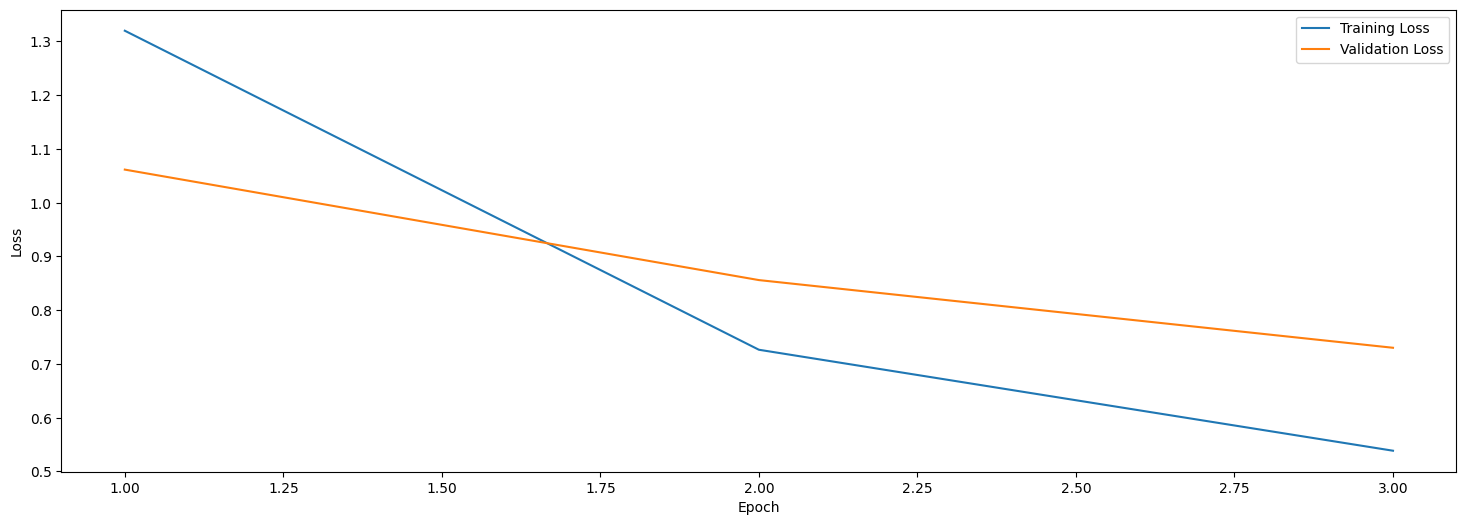

In [ ]:
# Save logs and plot metrics
logger.save_logs()
logger.plot()

# Tabel log

In [ ]:
# Create a dictionary to hold training statistics
training_stats = {
    'epoch': list(range(1, training_args.num_train_epochs + 1)),
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
}

# Create DataFrame from dictionary
df_stats = pd.DataFrame(training_stats)

# Set index to 'epoch'
df_stats = df_stats.set_index('epoch')

# Set display precision
pd.set_option('display.precision', 2)

# Drop rows with None values
df_stats = df_stats.dropna(axis=1, how='all')

# Print DataFrame
print(df_stats)

       loss  val_loss  f1_score
epoch                          
1      1.32      1.06       0.8
2      0.73      0.86       0.8
3      0.54      0.73       0.8


# Handler Out of Context

In [ ]:
# def provide_recommendation():
#     recommendation = ("Terima kasih atas pertanyaannya. Pertanyaan Anda terlalu kompleks untuk dijawab secara langsung. "
#                 "Namun, berikut beberapa rekomendasi yang mungkin dapat membantu mengelola keuangan Anda:\n\n"
                
#                 "1. **Buat anggaran:** Pantau pengeluaran Anda untuk mengidentifikasi area penghematan dan alokasi dana yang lebih efisien.\n\n"
                
#                 "2. **Cari pendapatan tambahan:** Pertimbangkan pekerjaan sampingan atau proyek paruh waktu untuk meningkatkan pendapatan Anda.\n\n"
                
#                 "3. **Investasi bijak:** Pelajari opsi investasi seperti saham, obligasi, atau properti. Konsultasikan dengan profesional keuangan jika perlu.\n\n"
                
#                 "4. **Kembangkan keterampilan:** Investasikan dalam pengembangan keterampilan dan pertimbangkan memonetisasi hobi atau minat Anda.\n\n"
                
#                 "5. **Perencanaan jangka panjang:** Buat rencana pensiun dan pastikan Anda memiliki perlindungan asuransi untuk risiko finansial.\n\n"
                
#                 "Semoga rekomendasi ini bermanfaat. Jika Anda membutuhkan bantuan lebih lanjut, jangan ragu untuk bertanya atau menggunakan fitur konsultasi dengan pakar keuangan kami. silahkan cek list expert di aplikasi kami.")
    
#     return recommendation


# Test Model

In [ ]:
# Create a dictionary mapping prompts to responses
prompt_response_dict = dict(zip(df['prompt'], df['response']))

# Add prompt to test the model
def generate_response(prompt):

    # First, check if the prompt is in the dataset
    if prompt in prompt_response_dict:
      return prompt_response_dict[prompt]

    context_keywords = ['keuangan', 'finansial', 'ekonomi', 'investasi', 'uang', 'budget', 'anggaran']
    is_finance_related = any(keyword in prompt.lower() for keyword in context_keywords)

    if not is_finance_related:
        return "Terima kasih atas pertanyaannya. Saya ingin menjelaskan bahwa peran saya di sini adalah untuk memberikan panduan dan rekomendasi seputar isu keuangan. Silakan ajukan pertanyaan terkait keuangan"

    # Ensure the prompt ends with appropriate punctuation
    if not prompt.endswith(('.', '?', '!', ':')):
        prompt += '.'

    inputs = tokenizer(prompt, return_tensors="tf", padding=True, truncation=True)
    prompt_output = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=100,
        num_return_sequences=1,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    response = tokenizer.decode(prompt_output[0], skip_special_tokens=True)

    # Ensure the response does not include the prompt
    response = response.replace(prompt, '').strip()

    # Ensure the response ends with a complete sentence
    if not prompt.endswith('.'):
        response = response.rsplit('.', 1)[0] + '.'

    THRESHOLD_LENGTH = 15
    if len(prompt.split()) > THRESHOLD_LENGTH:
        response += "\n\nJika Anda memerlukan penjelasan lebih lanjut atau bantuan dari seorang ahli, Anda dapat menggunakan fitur konsultasi dengan pakar keuangan kami, silahkan cek list expert di menu kami."

    return response

In [ ]:
# Test the model with a sample prompt
test_prompt = "apa itu finansial?"
response = generate_response(test_prompt)
print("Response:", response)

# Save model

In [ ]:
# Save the model at the end
model.save_pretrained("../models/gen-ai/fine_tuned_model")
tokenizer.save_pretrained("../models/gen-ai/fine_tuned_model")

In [ ]:
# Save the model in TensorFlow SavedModel format
# model.save('../models/gen-ai/model_gen_ai', save_format='tf')

# # Save the model weights only (optional)
# model.save_weights('../models/gen-ai/model_weights_gen_ai.h5')


In [ ]:
# # Kompres direktori output ke file zip
# !zip -r model.zip {training_args.output_dir}

# # Unduh file zip
# from google.colab import files
# files.download("model.zip")